In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import sklearn
import re
import scipy as sp
import os.path as op
import os
import matplotlib.pyplot as plt

sns.set(font='helvetica', context='talk', font_scale=1., style='white')

In [6]:
reg = re.compile('.*/sub-(?P<subject>[0-9]+)_mask-.')


In [7]:
root = '/data/risk_precision/ds-numrisk/'
output_dir = '/Users/gdehol/Science/numerosity_risk/paper/figures/'

In [8]:
n_versions = 5

pdf_ = glob.glob(f'{root}/derivatives/decoding_trialwise.v8/sub-*/func/sub-*_mask-NPC1*_desc-decodepdfs.pkl')

pdf = []

for p_ in pdf_:
    p = pd.read_pickle(p_)
    p1, p2 = p['pdf'], p['pars']
    p1.columns = np.round(np.exp(p['pdf'].columns.astype(float)), 3)
    p = pd.concat((p1, p2), keys=['pdf', 'pars'], axis=1)
    p['subject'] = int(reg.match(p_).group(1))
    p['run'] = np.repeat(range(1, 7), len(p) // 6)

    pdf.append(p.set_index(['subject', 'run'], append=True))



pdf = pd.concat(pdf)

pdf[('pars', 'stimulus')] = pdf.index.get_level_values('stimulus')
pdf = pdf.reorder_levels(['subject', 'run', 'mask', 'stimulus', 'log(stimulus)'])

In [9]:
interp = sp.interpolate.interp1d(pdf['pdf'].columns.values, pdf['pdf'], fill_value='extrapolate')
new_x = np.linspace(0, 50, 500)
pdf_new = pd.DataFrame(interp(new_x), columns=pd.Series(new_x, name='stimulus'), index=pdf['pdf'].index).astype(np.float)

stimulus_range_cols = pdf_new.columns[np.argmin((pdf_new.columns.values[:, np.newaxis] - np.array([5, 7, 10, 14, 20, 28])[np.newaxis, :])**2, 0)]

pdf[('pars', 'E[stimulus]')] = (pdf_new.columns.astype(float) * pdf_new).sum(1) / pdf_new.sum(1)
pdf[('pars', 'sd')] = np.sqrt((((pdf[('pars', 'E[stimulus]')].values[:, np.newaxis] - pdf_new.columns.values)**2) * pdf_new).sum(1) / pdf_new.sum(1))

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
import seaborn as sns

In [11]:
pdf.index.set_codes?

In [12]:
pdf.rename({"NPC1_L": 'Left NPC1', "NPC1_R":'Right NPC1'}, level='mask', inplace=True)

In [13]:
scale_invariance_dir = op.join(output_dir, 'neural_scale_invariance')

if not op.exists(scale_invariance_dir):
    os.makedirs(scale_invariance_dir)
    

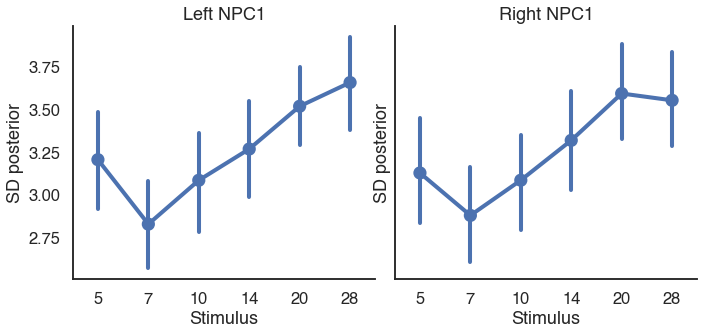

In [14]:
fac = sns.catplot('stimulus', 'sd', col='mask',
            data=pdf['pars'].drop('stimulus', 1).groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), kind='point')

fac.set_titles('{col_name}')
fac.set(ylabel='SD posterior', xlabel='Stimulus')
plt.savefig(op.join(scale_invariance_dir, 'scale_invariance.svg'))

In [15]:
import pingouin

In [20]:
tmp = pdf['pars'].drop('stimulus', 1).groupby(['subject', 'mask', 'stimulus']).mean().reset_index()
pingouin.rm_anova(tmp[tmp['mask'] == 'Left NPC1'], dv='sd', within='stimulus', subject='subject')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,stimulus,5,315,24.231,1.241647e-20,6.362982e-17,0.278,0.797,False,0.57,0.001845


In [22]:
tmp = pdf['pars'].drop('stimulus', 1).groupby(['subject', 'mask', 'stimulus']).mean().reset_index()
pingouin.rm_anova(tmp[tmp['mask'] == 'Right NPC1'], dv='sd', within='stimulus', subject='subject')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,stimulus,5,315,30.414,3.243235e-25,1.743609e-19,0.326,0.749,False,0.464,0.00002


In [23]:
pingouin.rm_corr(tmp[tmp['mask'] == 'Left NPC1'], y='sd', x='stimulus', subject='subject')

,r,dof,pval,CI95%,power
rm_corr,0.46,319,3.053526e-18,"[0.37, 0.54]",1.0


In [24]:
pingouin.rm_corr(tmp[tmp['mask'] == 'Right NPC1'], y='sd', x='stimulus', subject='subject')

,r,dof,pval,CI95%,power
rm_corr,0.499,319,1.384862e-21,"[0.41, 0.58]",1.0
